# Recommendations with IBM Watson Studio 
---
[Udacity Nanodegree in Data Science - Project 4](https://www.udacity.com/course/data-scientist-nanodegree--nd025)


In this project, I analyze the interactions that users have with articles on the IBM Watson Studio platform to make recommendations of new articles that might be of their interest.

The table of contents outlines the different methods for making recommendations that will be used in this notebook.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Conclusions, Actions and Future Directions](#conclusion)<br>

In [1]:
# Let's get started by importing the necessary libraries and reading in the data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./tests')
import project_tests as t
import pickle
from typing import List, Tuple
from itertools import permutations
from sklearn.metrics import accuracy_score

# Read raw data
df = pd.read_csv('data/user-item-interactions.csv').drop(columns=['Unnamed: 0'])
df_content = pd.read_csv('data/articles_community.csv').drop(columns=['Unnamed: 0'])

In [2]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>
---

First, let's use some descriptive statistics and basic visualization techniques to understand the data.

 - What is the distribution of how many articles a user interacts with an article in the dataset?  


In [6]:
def ECDF(
    array: np.array,
) -> Tuple[np.array, np.array]:
    """Empirical Cumulative Distribution Function. 
    
    Parameters
    ----------
    array : numpy array
        Array with datapoints. 
    
    Returns
    -------
    x : np.array
    y : np.array
    
    """
    y = np.linspace(0, 1, num=array.size)
    x = sorted(array)
    
    return x, y

`1.` Number of Interactions 
___

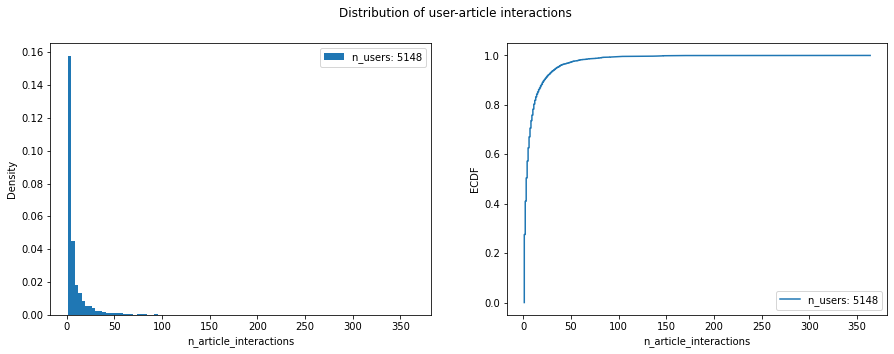

In [7]:
# get individual interactions 
n_unique_users = df.email.value_counts().index.size
n_interactions_by_user = df.email.value_counts().values

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(
    n_interactions_by_user,
    bins=100, density=True,
    label=f'n_users: {n_unique_users}'
)

axs[0].set(
    ylabel='Density',
    xlabel='n_article_interactions'
)

# plot the ECDF
x, y = ECDF(n_interactions_by_user)

axs[1].plot(
    x,
    y,
    label=f'n_users: {n_unique_users}'
)
axs[1].set(
    ylabel='ECDF',
    xlabel='n_article_interactions'
)

# Add legend
for i in range(2):
    axs[i].legend()

fig.suptitle('Distribution of user-article interactions')

plt.show()

In [8]:
median_val = np.median(n_interactions_by_user)
max_views_by_user = np.max(n_interactions_by_user)

print(f'50% of the users interact with {median_val} articles or fewer.')
print(f'The maximum number of user-article interactions is {max_views_by_user}.')

50% of the users interact with 3.0 articles or fewer.
The maximum number of user-article interactions is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Shape of the dataframe
df_content.shape

(1056, 5)

In [10]:
# How many duplicate articles exist?
n_duplicates_before = df_content.shape[0] - df_content.article_id.unique().size

print(f'The number of duplicate entries is {n_duplicates_before} articles.')

The number of duplicate entries is 5 articles.


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', inplace=True)

In [12]:
n_duplicates_after = df_content.shape[0] - df_content.article_id.unique().size

print(f'The number of duplicate entries after removal of duplicates is {n_duplicates_after} articles.')

The number of duplicate entries after removal of duplicates is 0 articles.


`3.` Other important information about the data:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [14]:
# The number of unique articles that have at least one interaction
if df.groupby(['article_id'])['email'].count().min() >= 1:
    unique_articles = df.groupby(['article_id'])['email'].count().index.size

# The number of unique articles on the IBM platform
total_articles = df_content.article_id.unique().size

# The number of unique users
unique_users = df.email.unique().size # includes 1 null user.

# The number of user-article interactions
user_article_interactions = df.shape[0]

In [15]:
print(f'The number of unique articles that have at least one interaction is {unique_articles}.')
print(f'The number of unique articles on the IBM platform is {total_articles}.')
print(f'The number of unique users is {unique_users}.')
print(f'The number of user-article interactions is {user_article_interactions}.')

The number of unique articles that have at least one interaction is 714.
The number of unique articles on the IBM platform is 1051.
The number of unique users is 5149.
The number of user-article interactions is 45993.


`4.` cells below show the most viewed **article_id**, as well as how often it was viewed.

In [16]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = df.groupby(['article_id'])['email'].count()\
                                                            .sort_values(ascending=False)\
                                                            .index[0]
        
# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby(['article_id'])['email'].count()\
                                               .sort_values(ascending=False)\
                                               .astype(str)\
                                               .iloc[0]


print(f'The most viewed article was {int(most_viewed_article_id)} with {max_views} views.')

The most viewed article was 1429 with 937 views.


### UDACITY MAINTENCANCE FUNCTION AND GRADER
---

After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
## UDACITY MAINTENANCE FUNCTION
## No need to change the code here - this will be helpful for later parts of the notebook
## Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            
            cter += 1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

In [18]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': int(max_views),
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users - 1, #  remove one null user
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>
---

There are several ways to quantify the rank of an article. For the purpose of this project and given that the data provided by UDACITY does not contain a rating (as proxy for whether a user liked an article or not), I will quantify the **popularity of an article based on how often an article was interacted with**.

`1.` The function below returns the **n** top articles ordered with most interactions as the top.

In [19]:
def get_top_articles(
    n: int,
    df: pd.DataFrame = df,
) -> List[str]:
    '''Return the n top article titles based on rank (ie most interactions).
    
    Parameters
    ----------
    n : int
        The number of top articles to return.
    df : pd.DataFrame 
        The df as defined at the top of the notebook.
    
    Returns
    -------
    top_articles : list
        A list of the top 'n' article titles. 
    
    '''
    
    # get the article ids
    top_articles_id = df.groupby(['article_id'])['user_id'].count()\
                                                           .sort_values(ascending=False)\
                                                           .iloc[:n]\
                                                           .index\
                                                           .tolist()
                                                           
    # get the article titles
    top_articles = df[df.article_id.isin(top_articles_id)].title\
                                                          .unique()\
                                                          .tolist()
    
    
    return top_articles

In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

### UDACITY GRADER
---

In [21]:
# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your to_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>
---

In order to implement user-user based collaborative filtering, I will consider whether an user interacted or not with an article. Other implementations could also consider the number of interactions or the rating of an individual article (for our current dataset, this information is missing). 


`1.` First, reformat the **df** dataframe to be shaped with users as the rows and articles as the columns. This implies:  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [22]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''Returns a user-item matrix.
    
    The matrix contains user ids as rows and article ids on the columns
    with 1 values where a user interacted with an article and a 0 otherwise.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with article_id, title, user_id columns.
    
    Returns
    -------
    user_item : pd.DataFrame
        The user-item matrix.
    '''
    
    # interactions any() 1 else 0
    user_item = df.groupby(['user_id', 'article_id']).any()\
                                                     .unstack()
    # not interactions counts as 0
    user_item.fillna(value=0, inplace=True)
    
    # replace bool True with 1
    user_item = user_item.astype(int)
    
    return user_item

# Create user-item matrix of interations
user_item = create_user_item_matrix(df)

### UDACITY GRADER
---

In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
def find_similar_users(
    user_id: int,
    user_item: pd.DataFrame = user_item,
) -> List[int]:
    '''Computes the similarity of every pair of users based on the dot product.
    
    Parameters
    ----------
    user_id : int
        An user_id.
    user_item : pd.DataFrame
        The matrix of users-by-articles: 
               - 1's when a user has interacted with an article,
               - 0 otherwise.
    
    Returns
    -------
    similar_users : list of int
        An ordered list where the closest users with
        the largest dot product are listed first.
        
    '''
    # get the user_id vector with article interaction info
    user_id_vector = user_item.loc[user_id, :]
    
    # Create dictionary to hold similarities with different users
    user_sim = {}
    
    # for each user to compare with...
    for user_2 in user_item.index:

        # the it is the same user, continue to the next user
        if user_id == user_2: 
            continue

        else:
            # get the user_2 vector with article interaction info
            user_2_vector = user_item.loc[user_2, :]

            # calculate dot product
            dot = np.dot(user_id_vector, user_2_vector)

            # add the result in the dictionary
            user_sim[user_2] = dot
    
    # Build the similarities dataframe
    temp_df = pd.DataFrame(
        {'user1': [user_id] * len(user_sim.keys()),
         'user2': user_sim.keys(),
         'similarity': user_sim.values()})

    # get sorted list of user_2 ids based on similarity
    most_similar_users = temp_df.sort_values('similarity', ascending=False)\
                                .user2\
                                .to_list()
    
    # return a list of the users in order from most to least similar
    return most_similar_users 

In [26]:
# Quick check on the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that the function that provides the most similar users to each user is ready, I can use these users to find articles you can recommend.

In [27]:
df['article_id'] = df['article_id'].astype(str)

In [28]:
def get_article_names(
    article_ids: List[str],
    df: pd.DataFrame = df,
) -> List[str]:
    '''Returns the titles of the articles based on article ids.
    
    Parameters
    ----------
    article_ids : list of str
        A list of article ids.
    df : pd.DataFrame 
     The dataframe df as defined at the top of the notebook.
    
    Returns
    -------
    article_names - list of str
        A list of article names associated with the list of article ids: 
            - this is identified by the title column.    
    '''
    
    # get article names based on ids
    article_names = df[df.article_id.isin(article_ids)]\
                                    .title\
                                    .unique()
    
    # Return the article names associated with list of article ids
    return article_names 


def get_user_articles(
    user_id: int,
    user_item: pd.DataFrame = user_item,
) -> Tuple[List[int], List[str]]:
    '''Provides a list of the article_ids and article titles that have been seen by a user_id.
    
    Parameters
    ----------
    user_id : int 
    A user id
    user_item - pd.DataFrame
        Matrix of users by articles: 
                - 1's when a user has interacted with an article,
                - 0 otherwise.
    
    Returns
    -------
    article_ids : list of int
        A list of the article ids seen by the user.
    article_names - list of str
        A list of article names associated with the list of article ids. 
        This is identified by the doc_full_name column in df_content.
    
    '''
    # condition to subset articles read by user
    article_read_by_user = user_item.loc[user_id].isin([1])

    # get articles id 
    article_ids = user_item.loc[user_id, article_read_by_user].unstack().columns.astype(str)

    # get article names based on ids
    article_names = get_article_names(article_ids, df=df)
    
    # return the ids and names
    return article_ids, article_names 


def user_user_recs(
    user_id: int,
    m: int = 10,
) -> List[str]:
    '''Returns the recommendations for a specific user_id.
    
    Parameters
    ----------
    user_id : int
        An user id.
    m : int
        The number of recommendations you want for the user.
    
    Returns
    -------
    recs : list of str 
        A list of recommendations for the user.
    
    Notes
    -----
    Loops through the users based on closeness to the input user_id.
    For each user - finds articles the user hasn't seen before and provides them as recs.
    Does this until m recommendations are found.
    
    
    Users who are the same closeness are chosen arbitrarily as the 'next' user.
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily.
    
    '''
    
    # Calculate similarities
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    # get articles that user read
    u1_article_ids, u1_article_names = get_user_articles(user_id, user_item=user_item)
    
    # instantiate list to hold recommendations
    recs = []
    
    # go 
    for u2 in similar_users:
        
        # get u2 article ids
        u2_article_ids, u2_article_names = get_user_articles(u2, user_item=user_item)
        
        # go over each article read by u2
        for u2_article_id in u2_article_ids:
            
            # Check if articles are new to user1 
            # and if they are already in recs
            if (u2_article_id not in u1_article_ids)\
               and (u2_article_id not in recs):
                
                #append to recs if n recs below threshold
                if len(recs) < m:
   
                    recs.append(str(u2_article_id))
                else:
                    break

        # if enough recs terminate search
        if len(recs) == m:
            break
    
    # return your recommendations for this user_id
    return recs 

In [29]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

array(['got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'graph-based machine learning',
       'using brunel in ipython/jupyter notebooks',
       'experience iot with coursera',
       'the 3 kinds of context: machine learning and the art of the frame',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty'],
      dtype=object)

### UDACITY GRADER
---

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` The next step is to improve the consistency of the **user_user_recs** function from above. Some extra layers can be added to the recommender:

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - **choose the users that have the most total article interactions before** choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, **choose articles with the articles with the most total interactions before** choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [31]:
def get_top_sorted_users(
    user_id: int,
    df: pd.DataFrame = df,
    user_item: pd.DataFrame = user_item,
) -> pd.DataFrame:
    '''Returns a dataframe with neighbor_id, similarity and num_interactions.
    
    Parameters
    ----------
    user_id : int
        The id of the user.
    df : pd.DataFrame
        df as defined at the top of the notebook.
    user_item : pd.DataFrame
        A matrix of users by articles: 
            - 1's when a user has interacted with an article,
            - 0 otherwise.
            
    Returns
    -------
    neighbors_df : pd.DataFrame
        A dataframe with:
            - neighbor_id: is a neighbor user_id
            - similarity: measure of the similarity of each user to the provided user_id.
            - num_interactions: the number of articles viewed by the user - if a u.
                    
    Notes
    -----
        neighbors_df is sorted by the similarity 
        and then by number of interactions where 
        highest of each is higher in the dataframe.
     
    '''
    
    # Get the interactions vector for user_id
    user_id_vector = user_item.loc[user_id, :]
    
    user_sim = {}
    interactions = []
    
    # for every user
    for user_2 in user_item.index:

        # the it is the same user, continue to the next
        if user_id == user_2: 
            continue

        else:
            # get user_2 vector
            user_2_vector = user_item.loc[user_2, :]

            # calculate dot (ie similarity)
            dot = np.dot(user_id_vector, user_2_vector)

            # append the result in a dictionary
            user_sim[user_2] = dot

            # calculate interactions
            n_interactions = df.groupby('user_id')['article_id'].count().loc[user_2]

            # collect interactions
            interactions.append(n_interactions)

    neighbors_df = pd.DataFrame(
        {'neighbor_id': user_sim.keys(),
         'similarity': user_sim.values(),
         'num_interactions': interactions},
    ).sort_values(by=['similarity', 'num_interactions'], ascending=False)

    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(
    user_id: int,
    m: int = 10,
) -> Tuple[List[int], List[str]]:
    '''Returns the recommendations for a specific user_id.

    Loops through the users based on closeness to the input user_id.
    For each user - finds articles the user hasn't seen before
    and provides them as recs. 
    Does this until m recommendations are found.
    
    Parameters
    ----------
    user_id : int
        An user id.
    m : int 
        The number of recommendations you want for the user.
    
    Returns
    -------
    recs : list
        A list of recommendations for the user by article id.
    rec_names : list
        A list of recommendations for the user by article title.
    
    Notes
    -----
    Choose the users that have the most total article interactions 
        before choosing those with fewer article interactions.

    Choose articles with the articles with the most total interactions 
        before choosing those with fewer total interactions. 
    '''
    
    # Calculate similarities
    similarity_df = get_top_sorted_users(user_id, user_item=user_item)
    
    # get articles that user read
    u1_article_ids, u1_article_names = get_user_articles(user_id, user_item=user_item)
    
    # create recommendations
    recs = []
    
    # go 
    for u2 in similarity_df.neighbor_id:
        
        # get u2 article ids
        u2_article_ids, u2_article_names = get_user_articles(u2, user_item=user_item)
        
        # go over each article read by u2
        for u2_article_id in u2_article_ids:
            
           
            if (u2_article_id not in u1_article_ids)\
               and (u2_article_id not in recs):
                
                #append to recs if n recs below threshold
                if len(recs) < m:
   
                    recs.append(str(u2_article_id))
                else:
                    break

        # if enough recs, then terminate search
        if len(recs) == m:
            break
        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [32]:
# Quick spot check
user_id = 20
n_recs = 10

rec_ids, rec_names = user_user_recs_part2(user_id, n_recs)

print(f"The top {n_recs} recommendations for user {user_id} are the following article ids:")
print(rec_ids, '\n')
print(f"The top {n_recs} recommendations for user {user_id} are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0'] 

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook'
 'dsx: hybrid mode' 'accelerate your workflow with dsx'
 'learn tensorflow and deep learning together and now!'
 "a beginner's guide to variational methods" 'tensorflow quick tips'
 'challenges in deep learning'
 'neural networks for beginners: popular types and applications'
 'statistics for hackers'
 'introduction to neural networks, advantages and applications']


### UDACITY GRADER
---
`5.` Verify the validity of the recommender.

In [33]:
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(user_id=1, df=df, user_item=user_item)['neighbor_id'].to_list()[0] 

In [34]:
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(user_id=131, df=df, user_item=user_item)['neighbor_id'].to_list()[9]

In [35]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` What about **new users**? Which of the above functions would be able to use to make recommendations?

Collaborative filtering is a powerful method to provide recommendations based on similarities between users. However this system does not work for new users since there will be no similarity (at least in the very beginning) with other users. Therefore, one way to bypass this _"cold start problem"_ would be to provide recommendations based on popularity (ie **Rand-based recommendations**) of articles among all users.


`7.` Let's Provide the top 10 recommended articles for the a new putative user below. 

In [36]:
new_user = '0.0'

# Get rank-based recommendations for user "0.0"
new_user_recs_article_names = get_top_articles(10)

# get article ids
new_user_recs = df[df.title.isin(get_top_articles(10))].article_id.unique()

print(f'The recommendations for new user {new_user} are:', )
for idx, rec in zip(new_user_recs, new_user_recs_article_names):
    print(f'{idx: <6} >>> {rec:<50}')

The recommendations for new user 0.0 are:
1314.0 >>> healthcare python streaming application demo      
1429.0 >>> use deep learning for image classification        
1170.0 >>> apache spark lab, part 1: basic concepts          
1364.0 >>> predicting churn with the spss random tree algorithm
1162.0 >>> analyze energy consumption in buildings           
1431.0 >>> visualize car data with brunel                    
1427.0 >>> use xgboost, scikit-learn & ibm watson machine learning apis
1304.0 >>> gosales transactions for logistic regression model
1330.0 >>> insights from new york car accident reports       
1293.0 >>> finding optimal locations of new store using decision optimization


### UDACITY GRADER
---

In [37]:
new_user_recs_article_ids = df[df.title.isin(new_user_recs)].article_id.unique().astype(str)

assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>
---

Matrix Factorization is a power technique to make recommendations to the users on the IBM Watson Studio platform.

`1.` This first question here will just require to run the cells below to get things set up for the rest of **Part V** of the notebook. 

In [38]:
# Load matrix
user_item_matrix = pd.read_pickle('data/user_item_matrix.p')

# quick look at the matrix
user_item_matrix.shape

(5149, 714)

`2.` First, let's use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  
**[Udacity Question]** - Explain why this is different than in the lesson.

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In this specific example, our data matrix is filled with binary inputs (1 for interaction, 0 for no interaction) and therefore there are no missing values. The presence of all values, even in highly sparse matrices is a precodition to use Single Value Decomposition.

In the lesson, the data matrix used to build the user-item matrix contained ratings and during aggregation of data, some of the values where absent due of the lack of reviews of a specific item by a specific user. Because the sparse matrix contanined NaNs, the usage of traditional Single Value Decomposition became imposssible. 

`3.` How do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.   

Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [40]:
num_latent_feats = np.arange(start=10, stop=700+10, step=20)
sum_errs = []
acc = [] # Accuracy sklearn

for k in num_latent_feats:
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    accucary = accuracy_score(user_item_matrix.to_numpy().flatten(), user_item_est.flatten())
    
    sum_errs.append(err)
    acc.append(accucary)

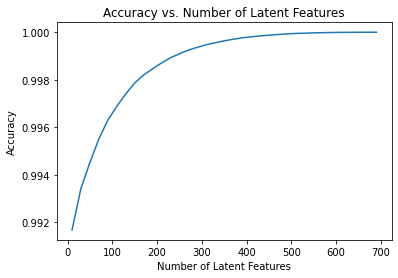

In [41]:
fig, ax = plt.subplots()    

ax.plot(
    num_latent_feats,
    acc,
);

ax.set(
    xlabel='Number of Latent Features',
    ylabel='Accuracy',
    title='Accuracy vs. Number of Latent Features',
);


`4.` From the above, it is difficult to be sure about how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.

Another strategy is to implement a division of the dataset into training and testing subsets and perform decomposition on the training with increasing number of latent features and evaluate the result on the test subset. 


In [42]:
# divive the main dataframe into train and test subsets
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''Split user-item matrix into train and test sets.
    
    Parameters
    ----------
    df_train : pd.DataFrame
        Training dataframe
    df_test : pd.DataFrame
        Test dataframe
    
    Returns
    -------
    user_item_train : pd.DataFrame
        A user-item matrix of the training dataframe with
        unique users for each row and unique articles for each column.
    user_item_test : pd.DataFrame
        A user-item matrix of the testing dataframe 
        unique users for each row and unique articles for each column.    
    test_idx : np.array
        All of the test user ids.   
    test_arts : np.array
        All of the test article ids.
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    
    test_arts = user_item_test.columns.get_level_values(1)
    
    
    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

`Q4.1` How many users can we make predictions for in the test set?  

In [43]:
answer4_1 = user_item_train.index.isin(test_idx).sum()

print(f'We can make predictions for {answer4_1} users in the test dataset.')

We can make predictions for 20 users in the test dataset.


##### `Q4.2` How many users are we not able to make predictions for because of the cold start problem?

In [44]:
answer4_2 = user_item_test.index.unique().size - answer4_1

print(f'We cannot make predictions for {answer4_2} users in the test dataset.')

We cannot make predictions for 662 users in the test dataset.


##### `Q4.3` How many articles can we make predictions for in the test set?    
*In other words, how many articles of the test dataset are contained in the train dataset?*

In [45]:
answer4_3 = user_item_train.columns.get_level_values(1)\
                                   .isin(test_arts)\
                                   .sum()

print(f'We are able to make predictions for {answer4_3} articles.')

We are able to make predictions for 574 articles.


##### `Q4.4` How many articles are we not able to make predictions for because of the cold start problem? 


In [46]:
answer4_4 = user_item_test.columns.get_level_values(1).size - answer4_3

print(f'We are NOT able to make predictions for {answer4_4} articles.')

We are NOT able to make predictions for 0 articles.


### UDACITY GRADER
---

In [47]:
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now let's use the **user_item_train** dataset from above to find U, S, and V transpose using SVD.   

To find the appropriate number of latent features necessary to provide good results on the test set, we can: 

1 - find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

**How well SVD works towards making predictions for recommendations on the test data?**

In [48]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [49]:
# find common ids in train and test (ie ROWs)
common_ids = user_item_train.index[user_item_train.index.isin(test_idx)]

# get conditions to subset user_item_test matrix
test_row_bool = user_item_test.index.isin(common_ids)
train_row_bool = user_item_train.index.isin(common_ids)

# Subset columns
train_columns_bool = user_item_train.columns.get_level_values(1).isin(test_arts)

In [50]:
num_latent_feats = np.arange(10,700+10,20)

# Absolute error scores
sum_errs_train = []
sum_errs_test = []

# Accuracy scores
score_train = []
score_test = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est_train_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    train_sub_est = user_item_est_train_est[train_row_bool][:, train_columns_bool]
    
    # subset matrices for common users/common articles
    test_sub = user_item_test.to_numpy()[test_row_bool, :]
    train_sub = user_item_train.to_numpy()[train_row_bool][:, train_columns_bool]
    
    diffs_train = np.subtract(train_sub, train_sub_est)
    diff_test = np.subtract(test_sub, train_sub_est)
    
    # Calculate total error and store it
    # Absolute error
    err_train = np.sum(np.abs(diffs_train))
    err_test = np.sum(np.abs(diff_test))
    
    # Accurary
    score_train.append(accuracy_score(train_sub.flatten(), train_sub_est.flatten()))
    score_test.append(accuracy_score(test_sub.flatten(), train_sub_est.flatten()))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)


What is the impact on accuracy of the training and test sets of data with different numbers of latent features?

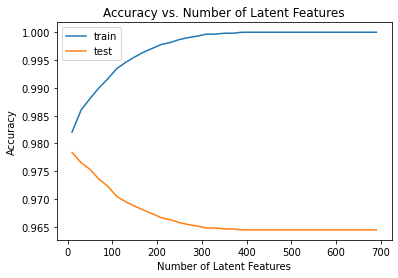

In [51]:
fig, ax = plt.subplots()

ax.plot(
    num_latent_feats,
    score_train,
    label='train'
);
ax.plot(
    num_latent_feats,
    score_test,
    label='test'

)

ax.set(
    xlabel='Number of Latent Features',
    ylabel='Accuracy',
    title='Accuracy vs. Number of Latent Features',
);

plt.legend();

### <a class="anchor" id="conclusion">Part V: Conclusions, Actions and Future Directions</a>

---

Our plot shows that we are able to get accurate predictions on the **training dataset** when we use an increasingly high number of latent features.

However, when we evaluate our method with the **test dataset**, we can see that the performance decreases with an increasingly higher number of features. Because we have only 20 users and a highly imbalanced dataset (far more negative class compared to positive), we would need to **increase the number of users and article interactions in our dataset** in order to have better results.

**Current issues and challenges**


A fundamental issue with the dataset and approach used in this section (Matrix factorization and SVD) is that we do not have information about whether users like the article or not (i.e. no rating), and we also do not consider the total number of interactions (only interaction vs no interaction). 
Therefore __we have no information about whether the recommendations are useful or relevant__. 

**Actionable Items and Future Directions** 

* Start by deploying the User-User Based Collaborative Filtering for existing users and Rank-based recommendations for new users.
* Evaluate current solutions (Rank-based and User-User Collaborative Filtering) with a A/B TEST, comparing the number of interactions for users before and after deplyoing the solution. A good recommender should lead to an increase of the number of interactions for users.
* Ask quantitative user feedback (e.g. a rating from 1-10) in the environment where the recommender is deployed. 
* Combine new user rating information and total number of interactions in a single, ensemble system to make more reliable recommendations. 

In [ ]:
# To generate an html view of this notebook
! python -m nbconvert --to html Recommendations_with_IBM.ipynb

---
2021 - [Jose Oliveira da Cruz](https://github.com/joseferncruz)